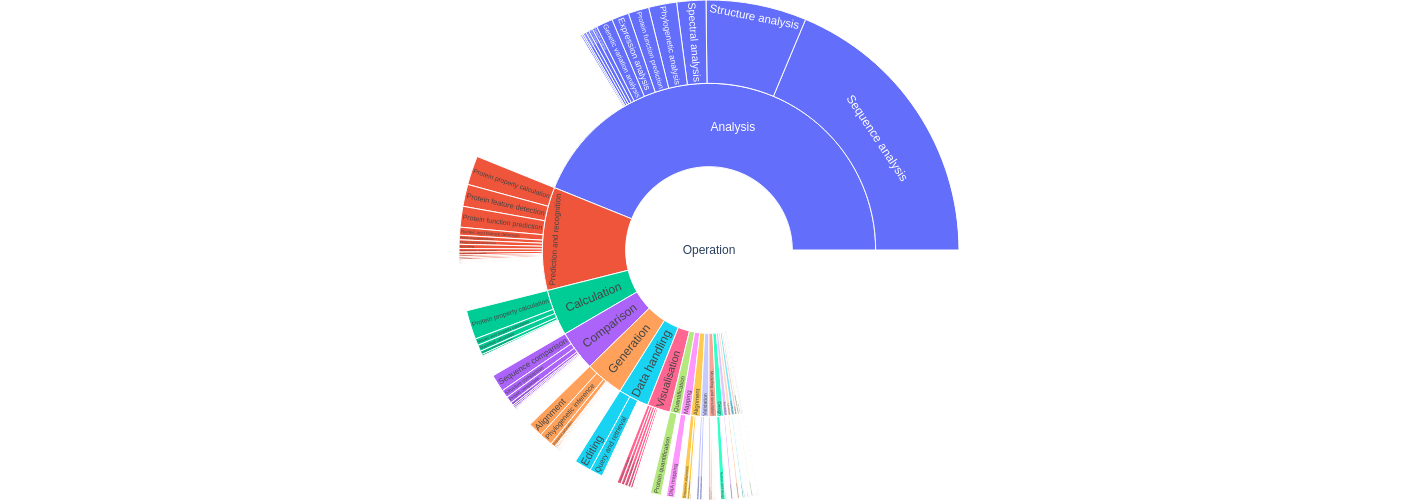

In [17]:
from owlready2 import get_ontology
import plotly.graph_objects as go

EDAM_FILE_PATH = "/home/hmenager/edamontology/EDAM_dev.owl"
EDAM = get_ontology(EDAM_FILE_PATH).load()

def class_label(class_node):
    try:
        return class_node.label.first()
    except:
        return class_node.iri

def get_sunburst_data(node, sunburst_data=None, path="", value_fn=lambda x:1):
    if sunburst_data==None:
        sunburst_data = {
                 "ids":[],
                 "labels":[],
                 "parents":[],
                 "values":[]}
    value = value_fn(node)
    id = f"{path}>{node.name}"
    for child in node.subclasses():
        sunburst_data, child_value = get_sunburst_data(child, sunburst_data, id, value_fn)
        value += child_value
    sunburst_data["ids"].append(id)
    sunburst_data["labels"].append(class_label(node))
    sunburst_data["parents"].append(path)
    sunburst_data["values"].append(value)
    return sunburst_data, value

def display_sunburst(sunburst_data):
    fig =go.Figure(go.Sunburst(
        ids = sunburst_data["ids"],
        labels = sunburst_data["labels"],
        parents = sunburst_data["parents"],
        values = sunburst_data["values"],
        maxdepth=3 #number of levels shown on the sunburst diagram
    ))
    fig.update_layout(margin = dict(t=0, l=0, r=0, b=0), height=500)
    fig.show()

sunburst_data, root_node_value = get_sunburst_data(EDAM["operation_0004"])

display_sunburst(sunburst_data)

In [13]:
from rdflib import Graph
from rdflib.plugins.sparql import prepareQuery

# Load bio.tools serialized as a bioschemas file
biotools = '/home/hmenager/content/datasets/bioschemas-dump.ttl'
g = Graph()
g.parse(biotools, format='ttl')  # You can adjust the format based on your RDF file type

# count the number of times an EDAM operation is used for bio.tools entries
operation_sparql_query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX sc: <http://schema.org/>
    SELECT (COUNT(?id) AS ?count) ?operation
    WHERE {
        ?id  a sc:SoftwareApplication .
        ?id sc:featureList ?operation
    }
    GROUP BY ?operation
"""

# Prepare the query
query = prepareQuery(operation_sparql_query)

# Execute the query and print the results
results = g.query(query)
biotools_operations = {}
for row in results:
    biotools_operations[str(row["operation"])] = int(row["count"])
print("bio.tools operations loaded")


bio.tools operations loaded


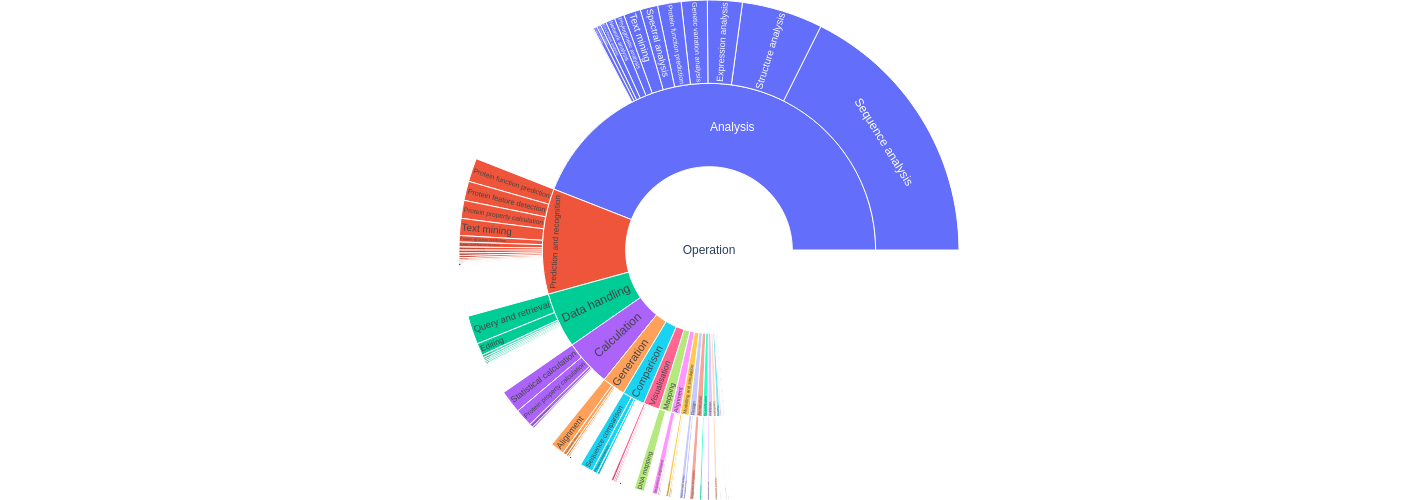

In [23]:
def operation_usage(operation):
    #print(operation.iri, biotools_operations.get(operation.iri, 0))
    return biotools_operations.get(operation.iri, 0)

sunburst_data, root_node_value = get_sunburst_data(EDAM["operation_0004"], None, "", operation_usage)
# print(sunburst_data)
display_sunburst(sunburst_data)